In [4]:
versioninfo()

using Pkg

Pkg.activate(pwd())

Pkg.instantiate()
Pkg.status()


Julia Version 1.11.3
Commit d63adeda50 (2025-01-21 19:42 UTC)
Build Info:
  Built by Homebrew (v1.11.3)

    Note: This is an unofficial build, please report bugs to the project
    responsible for this build and not to the Julia project unless you can
    reproduce the issue using official builds available at https://julialang.org/downloads

Platform Info:
  OS: macOS (arm64-apple-darwin24.2.0)
  CPU: 16 × Apple M4 Max
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, apple-m1)
Threads: 12 default, 0 interactive, 6 GC (on 12 virtual cores)
Environment:
  JULIA_NUM_THREADS = 12


  Activating project at `~/codes/Julia/MyPack/Dykstra`
Precompiling project...
   1795.0 ms  ✓ DifferentiationInterface → DifferentiationInterfaceForwardDiffExt
    516.3 ms  ✓ NLSolversBase
    787.8 ms  ✓ LineSearches
   1188.6 ms  ✓ Optim


Project Dykstra v0.1.0
Status `~/codes/Julia/MyPack/Dykstra/Project.toml`
  [198e06fe] BangBang v0.4.6
  [b4f34e82] Distances v0.10.12
  [817d07cb] FixedPointAcceleration v1.1.0
  [f6369f11] ForwardDiff v1.3.0
⌃ [d3d80556] LineSearches v7.4.1
  [bdcacae8] LoopVectorization v0.12.173
⌃ [b8f27783] MathOptInterface v1.46.0
  [59ddf330] NearestCorrelationMatrix v1.1.1
⌃ [429524aa] Optim v1.13.2
  [a725b495] ProximalOperators v0.16.1
  [10745b16] Statistics v1.11.1
  [37e2e46d] LinearAlgebra v1.11.0
  [de0858da] Printf v1.11.0
  [9a3f8284] Random v1.11.0
  [2f01184e] SparseArrays v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


  15300.5 ms  ✓ Optim → OptimMOIExt
  5 dependencies successfully precompiled in 20 seconds. 146 already precompiled.


In [1]:
using Distributions, Random, ProximalOperators
using DataFrames, PrettyTables, Statistics, LinearAlgebra, Printf
using BenchmarkTools
using Plots, LaTeXStrings
using ExactOptimalTransport
using Gurobi
using MathOptInterface
const MOI = MathOptInterface

include("src/Dykstra.jl")
using .Dykstra


## Example 1

## Halfspaces

In [9]:

median_ms(bt) = median(bt.times) / 1e6    # ns → ms

function benchmark_one(n::Int; seed::Int = 2025)
    Random.seed!(seed)

    x = 10 .* rand(n)
    x = sort(x; rev = true)
    x[1] = 10 * x[1]

    a1 = zeros(n); a1[end] = -1.0
    a2 = zeros(n); a2[end] = -10.0   # condition number = 10
    a2[1] = 1.0

    specs = [
        (type=:halfspace, α = a1, c = 0.0),
        (type=:halfspace, α = a2, c = 0.0),
        (type=:monoDec,  p = n),
    ]

    r = length(specs)
    rLambda = zeros(n, r)
    x0      = similar(x)

    sets = build_sets(specs; p = length(specs))   # 沿用你原来的写法
    C    = sets[end]

    A = hcat(a1, a2)
    b = zeros(2)

    kwargs2 = (
        A         = A,
        b         = b,
        mode      = :halfspaces,  # hyperplane, halfspaces
        tol       = 1e-12,
        max_outer = 100,
    )

    kwargs = (
        m        = 4,       # memory
        tol      = 1e-12,
        τ        = 1.0,
        maxiter  = 10000,
        λ        = 1e-12,
        cnd_max  = 1e8,
    )

    xN2, λ2, iters2, state2 = project_halfspaces_active_set(C, x; kwargs2...)

    x_AAI,  Λ_AAI,  iters_AAI,  ok_AAI  =
        run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant=:AAI,  kwargs...)
    x_Dy,   Λ_Dy,   iters_Dy,   ok_Dy   =
        run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant=:none, kwargs...)

    btime_Newton = @benchmark project_halfspaces_active_set($C, $x; $kwargs2...)
    btime_AAI    = @benchmark run_dykstra!((copy($x0)), (copy($x)), (copy($rLambda)), $sets; AAvariant=:AAI,  $kwargs...)
    btime_Dykstra= @benchmark run_dykstra!((copy($x0)), (copy($x)), (copy($rLambda)), $sets; AAvariant=:none, $kwargs...)

    return (
        n        = n,
        it_AAI   = iters_AAI,
        it_Dyk   = iters_Dy,
        it_Newton= iters2,
        t_AAI    = median_ms(btime_AAI),
        t_Dyk    = median_ms(btime_Dykstra),
        t_Newton = median_ms(btime_Newton),
    )
end

Ns = [100, 1_000, 10_000, 100_000, 1_000_000]
rows_n = Vector{NamedTuple}(undef, length(Ns))

for (k, n) in enumerate(Ns)
    println("Benchmarking n = $n ...")
    rows_n[k] = benchmark_one(n)
end

df_n = DataFrame(rows_n)

println(df_n)

header_n = [
    "n",
    "Iters (AAI)",
    "Iters (Dykstra)",
    "Iters (Newton)",
    "Time AAI (ms)",
    "Time Dykstra (ms)",
    "Time Newton (ms)",
]

pretty_table(df_n;
    header = header_n,
    formatters = (
        ft_printf("%d", 1:4),
        ft_printf("%.3f", 5:7),
    ),
)

# LaTeX 输出
io = IOBuffer()
pretty_table(io, df_n;
    header = header_n,
    tf = tf_latex_booktabs,
    formatters = (
        ft_printf("%d", 1:4),
        ft_printf("%.3f", 5:7),
    ),
)
println("\nLaTeX Table Output:\n")
println(String(take!(io)))

default(
    guidefont   = font(12),
    tickfont    = font(10),
    legendfont  = font(10),
    legend      = :bottomright,
    lw          = 2.5,
    markersize  = 5,
)

n_vals    = df_n.n
t_AAI     = df_n.t_AAI
# t_AAII    = df_n.t_AAII
t_Dyk     = df_n.t_Dyk
t_Newton  = df_n.t_Newton

ex_x      = 2:8
xtick_pos = 10.0 .^ ex_x
xtick_lab = [latexstring("10^{", k, "}") for k in ex_x]

ex_y      = -2:8
ytick_pos = 10.0 .^ ex_y
ytick_lab = [latexstring("10^{", k, "}") for k in ex_y]

p = plot(
    n_vals, t_Newton;
    xscale = :log10,
    yscale = :log10,
    xticks = (xtick_pos, xtick_lab),
    yticks = (ytick_pos, ytick_lab),
    xlabel = L"n",
    ylabel = L"\mathrm{Time}\;(\mathrm{ms})",
    label  = "Newton",
    marker = :circle,
    size   = (520, 420),
)

plot!(p, n_vals, t_AAI;   label="Dykstra (AA-I)",  marker=:utriangle, linestyle=:dash)
plot!(p, n_vals[1:3], t_Dyk[1:3];  label="Dykstra", marker=:diamond, linestyle=:dot)
# plot!(p, n_vals, t_Newton;label="Newton",         marker=:diamond,   linestyle=:dot)

savefig(p, "dykstra_newton_benchmarks.pdf")
display(p)



Benchmarking n = 100 ...
Benchmarking n = 1000 ...
Benchmarking n = 10000 ...
Benchmarking n = 100000 ...
Benchmarking n = 1000000 ...
5×7 DataFrame
 Row │ n        it_AAI  it_Dyk  it_Newton  t_AAI        t_Dyk        t_Newton   
     │ Int64    Int64   Int64   Int64      Float64      Float64      Float64    
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     100      16    1188          6     0.106          2.438     0.038208
   2 │    1000      17    2334          6     0.895813      40.1838    0.212438
   3 │   10000      14    2777          6     8.04308      521.959     1.84488
   4 │  100000      22   10000          8   148.714      25179.4      35.3824
   5 │ 1000000      33   10000          8  2039.06      171874.0     322.416
┌─────────┬─────────────┬─────────────────┬────────────────┬───────────────┬───────────────────┬──────────────────┐
│       n │ Iters (AAI) │ Iters (Dykstra) │ Iters (Newton) │ Time AAI (ms) │ Time Dykstra (ms) │ T

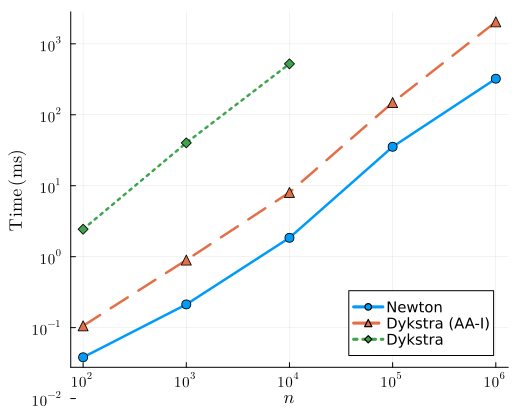

In [10]:
using Plots, LaTeXStrings

default(
    guidefont   = font(12),
    tickfont    = font(10),
    legendfont  = font(10),
    legend      = :bottomright,
    lw          = 2.5,
    markersize  = 5,
)

n_vals    = df_n.n
t_AAI     = df_n.t_AAI
# t_AAII    = df_n.t_AAII
t_Dyk     = df_n.t_Dyk
t_Newton  = df_n.t_Newton

ex_x      = 2:8
xtick_pos = 10.0 .^ ex_x
xtick_lab = [latexstring("10^{", k, "}") for k in ex_x]

ex_y      = -2:8
ytick_pos = 10.0 .^ ex_y
ytick_lab = [latexstring("10^{", k, "}") for k in ex_y]

p = plot(
    n_vals, t_Newton;
    xscale = :log10,
    yscale = :log10,
    xticks = (xtick_pos, xtick_lab),
    yticks = (ytick_pos, ytick_lab),
    xlabel = L"n",
    ylabel = L"\mathrm{Time}\;(\mathrm{ms})",
    label  = "Newton",
    marker = :circle,
    size   = (520, 420),
)

plot!(p, n_vals, t_AAI;   label="Dykstra (AA-I)",  marker=:utriangle, linestyle=:dash)
plot!(p, n_vals[1:3], t_Dyk[1:3];  label="Dykstra", marker=:diamond, linestyle=:dot)
# plot!(p, n_vals, t_Newton;label="Newton",         marker=:diamond,   linestyle=:dot)

savefig(p, "dykstra_newton_benchmarks.pdf")
display(p)



## Example: Intersection of six hyperplane and a simplex

In [11]:
Random.seed!(2025)

m, ρ, σ = 6, 0.9, 1.0
R = fill(ρ, m, m); @inbounds for i in 1:m R[i,i] = 1.0 end
Σ = (σ^2) .* R
dist = MvNormal(zeros(m), Σ)

n = 1000
samples = rand(dist, n)
c_list  = [vec(samples[i, :]) for i in 1:m]
A = hcat(c_list...)
b = randn(m)
x = randn(n)

specs = [
    (type=:affine, α=Matrix(A'), c=b),
    (type=:simplex,   c=10.0),
]

r = length(specs)
rLambda = zeros(n, r);
x0 = similar(x);

sets = build_sets(specs; p=length(specs));

C = sets[end]

kwargs2 = (
    A=A, 
    b=b, 
    mode=:hyperplane,  # hyperplane, halfspaces
    tol=1e-10, 
    max_outer=100
)

kwargs = (
#     variant  = :AAI,   # :AAI or :AAII
    m        = 4,      # memory
    tol      = 1e-10,   # stopping tolerance
    τ        = 1.0,    # damping
    # optional extras if your runner accepts them:
    maxiter  = 10000,
    λ        = 1e-12,
    cnd_max  = 1e8,
)


xN2, λ2, iters2, state2 = project_halfspaces_active_set(C, x; kwargs2...)
btime2 = @benchmark project_halfspaces_active_set(C, x; kwargs2...)

x_AAI, Λ_AAI, iters_AAI, ok_AAI = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAI, kwargs...)
b1 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAI, kwargs...)

# x_AAII, Λ_AAII, iters_AAII, ok_AAII = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAII, kwargs...)
# b2 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAII, kwargs...)

x_Dy, Λ_Dy, iters_Dy, ok_Dy = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :none, kwargs...)
b3 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :none, kwargs...)



median_us(bt) = median(bt.times) / 1e6  # ns -> μs

function one_row(label::AbstractString, C, A, b, yN, x, iters, btime)
    max_v = maximum(A' * yN .- b)
    min_v = minimum(A' * yN .- b)
    proj_res = norm(prox(C, yN)[1] .- yN, 2)
    t_time = median(btime.times) / 1e6  # 
    
    Dist = norm(x.- yN, 2)
    
    return (Label=label, Iters=iters,
            Max_violation=max_v, Min_violation=min_v,
            Dist = Dist,
            Proj_residual=proj_res, Time=t_time)
end

rows = [
    one_row("Dykstra AAI",  C, A, b, x_AAI,  x, iters_AAI,  b1),
#     one_row("Dykstra AAII", C, A, b, x_AAII, x, iters_AAII, b2),
    one_row("Dykstra",      C, A, b, x_Dy,   x, iters_Dy,   b3),
    one_row("Newton",       C, A, b, xN2,    x, iters2,     btime2),
]

df = DataFrame(rows)

header = ["Method / Mode", "Iters", "max(Aᵀy − b)", "min(Aᵀy − b)", "‖y − x‖₂", "‖Π_C(y) − y‖₂", "Time (ms)"]

pretty_table(df;
    header = header,
    formatters = (
        ft_printf("%.10f", 5),
        ft_printf("%.3e", 3:4),
        ft_printf("%.3e", 6),
        ft_printf("%.3f", 7),
    ),
)

# -------- LaTeX output --------
io = IOBuffer()
pretty_table(io, df;
    header=header,
    tf=tf_latex_booktabs,
    formatters = (
        ft_printf("%.10f", 5),
        ft_printf("%.3e", 3:4),
        ft_printf("%.3e", 6),
        ft_printf("%.3f", 7),
    ),
)

println("\nLaTeX Table Output:")
println(String(take!(io)))



┌───────────────┬───────┬──────────────┬──────────────┬───────────────┬───────────────┬───────────┐
│ Method / Mode │ Iters │ max(Aᵀy − b) │ min(Aᵀy − b) │      ‖y − x‖₂ │ ‖Π_C(y) − y‖₂ │ Time (ms) │
├───────────────┼───────┼──────────────┼──────────────┼───────────────┼───────────────┼───────────┤
│   Dykstra AAI │   460 │    2.628e-09 │   -9.036e-09 │ 30.3726354266 │     3.890e-14 │    24.492 │
│       Dykstra │  1437 │    1.074e-08 │    2.175e-10 │ 30.3726354265 │     9.547e-15 │    27.041 │
│        Newton │     6 │    9.104e-15 │   -1.865e-14 │ 30.3726354265 │     6.617e-15 │     0.356 │
└───────────────┴───────┴──────────────┴──────────────┴───────────────┴───────────────┴───────────┘

LaTeX Table Output:
\begin{tabular}{rrrrrrr}
  \toprule
  \textbf{Method / Mode} & \textbf{Iters} & \textbf{max(Aᵀy − b)} & \textbf{min(Aᵀy − b)} & \textbf{‖y − x‖₂} & \textbf{‖Π\_C(y) − y‖₂} & \textbf{Time (ms)} \\\midrule
  Dykstra AAI & 460 & 2.628e-09 & -9.036e-09 & 30.3726354266 & 3.890e-14 & 

## Example 1.1 intersection of six halfspaces and a simplex

In [12]:
Random.seed!(2025)

m, ρ, σ = 6, 0.95, 1.0
R = fill(ρ, m, m); @inbounds for i in 1:m R[i,i] = 1.0 end
Σ = (σ^2) .* R
dist = MvNormal(zeros(m), Σ)

n = 1000
samples = rand(dist, n)
c_list  = [vec(samples[i, :]) for i in 1:m]
A = hcat(c_list...)
b = randn(m)
x = rand(n)

specs = [
    (type=:halfspace, α=A[:,1], c=b[1]),
    (type=:halfspace, α=A[:,2], c=b[2]),
    (type=:halfspace, α=A[:,3], c=b[3]),
    (type=:halfspace, α=A[:,4], c=b[4]),
    (type=:halfspace, α=A[:,5], c=b[5]),
    (type=:halfspace, α=A[:,6], c=b[6]),
    (type=:simplex,   c=1.0),
    # (type=:ballL2,   ρ=1.0),
    # (type=:ballL1,   ρ=1.2),
    # (type=:ballLinf, ρ=2.0),
    # (type=:affine,   α=αvec, c=c0),
#     (type=:box,      low=0.0, high=Inf, p=length(x0)),
    # (type=:box,      lo_vec=lo, hi_vec=hi),
]

r = length(specs)
rLambda = zeros(n, r);
x0 = similar(x);

sets = build_sets(specs; p=length(specs));

C = sets[end]

kwargs2 = (
    A=A, 
    b=b, 
    mode=:halfspaces,
    tol=1e-10, 
    max_outer=100
)


kwargs = (
#     variant  = :AAI,   # :AAI or :AAII
    m        = 4,      # memory
    tol      = 1e-10,   # stopping tolerance
    τ        = 1.0,    # damping
    # optional extras if your runner accepts them:
    maxiter  = 10000,
    λ        = 1e-10,
    cnd_max  = 1e8,
)

xN2, λ2, iters2, state2 = project_halfspaces_active_set(C, x; kwargs2...)
btime2 = @benchmark project_halfspaces_active_set(C, x; kwargs2...)

x_AAI, Λ_AAI, iters_AAI, ok_AAI = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAI, kwargs...)
b1 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAI, kwargs...)

# x_AAII, Λ_AAII, iters_AAII, ok_AAII = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAII, kwargs...)
# b2 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAII, kwargs...)

x_Dy, Λ_Dy, iters_Dy, ok_Dy = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :none, kwargs...)
b3 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :none, kwargs...)

function one_row(label::AbstractString, C, A, b, yN, x, iters, btime)
    max_v = maximum(A' * yN .- b)
    min_v = minimum(A' * yN .- b)
    proj_res = norm(prox(C, yN)[1] .- yN, 2)
    t_time = median(btime.times) / 1e6  # 
    
    Dist = norm(x.- yN, 2)
    
    return (Label=label, Iters=iters,
            Max_violation=max_v, Min_violation=min_v,
            Dist = Dist,
            Proj_residual=proj_res, Time=t_time)
end

rows = [
    one_row("Dykstra AAI",  C, A, b, x_AAI,  x, iters_AAI,  b1),
#     one_row("Dykstra AAII", C, A, b, x_AAII, x, iters_AAII, b2),
    one_row("Dykstra",      C, A, b, x_Dy,   x, iters_Dy,   b3),
    one_row("Newton",       C, A, b, xN2,    x, iters2,     btime2),
]

df = DataFrame(rows)

header = ["Method / Mode", "Iters", "max(Aᵀy − b)", "min(Aᵀy − b)", "‖y − x‖₂", "‖Π_C(y) − y‖₂", "Time (ms)"]

pretty_table(df;
    header = header,
    formatters = (
        ft_printf("%.10f", 5),
        ft_printf("%.3e", 3:4),
        ft_printf("%.3e", 6),
        ft_printf("%.3f", 7),
    ),
)

# -------- LaTeX output --------
io = IOBuffer()
pretty_table(io, df;
    header=header,
    tf=tf_latex_booktabs,
    formatters = (
        ft_printf("%.10f", 5),
        ft_printf("%.3e", 3:4),
        ft_printf("%.3e", 6),
        ft_printf("%.3f", 7),
    ),
)

println("\nLaTeX Table Output:")
println(String(take!(io)))



┌───────────────┬───────┬──────────────┬──────────────┬───────────────┬───────────────┬───────────┐
│ Method / Mode │ Iters │ max(Aᵀy − b) │ min(Aᵀy − b) │      ‖y − x‖₂ │ ‖Π_C(y) − y‖₂ │ Time (ms) │
├───────────────┼───────┼──────────────┼──────────────┼───────────────┼───────────────┼───────────┤
│   Dykstra AAI │    18 │    1.755e-09 │   -4.298e+00 │ 17.7770428154 │     4.255e-15 │     1.833 │
│       Dykstra │  5816 │    2.412e-08 │   -4.298e+00 │ 17.7770428152 │     1.963e-14 │   173.909 │
│        Newton │     5 │   -9.948e-14 │   -4.298e+00 │ 17.7770428154 │     8.965e-15 │     0.197 │
└───────────────┴───────┴──────────────┴──────────────┴───────────────┴───────────────┴───────────┘

LaTeX Table Output:
\begin{tabular}{rrrrrrr}
  \toprule
  \textbf{Method / Mode} & \textbf{Iters} & \textbf{max(Aᵀy − b)} & \textbf{min(Aᵀy − b)} & \textbf{‖y − x‖₂} & \textbf{‖Π\_C(y) − y‖₂} & \textbf{Time (ms)} \\\midrule
  Dykstra AAI & 18 & 1.755e-09 & -4.298e+00 & 17.7770428154 & 4.255e-15 & 1

## Example 1.2 Three Balls and a Simplex

In [13]:
Random.seed!(2025)

n = 500
m, ρ, σ = 3, 0.2, 1.0
R = fill(ρ, m, m); @inbounds for i in 1:m R[i,i] = 1.0 end
Σ = (σ^2) .* R
dist = MvNormal(zeros(m), Σ)
x = rand(n)

C = IndSimplex(1.0)

y_star = make_projector(C)(rand(n))   # projuct to C as intersection point

A = rand(dist, n)
# A = zeros(m, n)
c_list  = [vec(A[i, :]) for i in 1:m]

r_ball   = radii_from_target(y_star, c_list; mode=:ball, slack=0.1)     # ball
r_shpere = radii_from_target(y_star, c_list; mode=:sphere)            # sphere

m = min(size(A,2), length(r_ball))
specs = NamedTuple[]
for j in 1:m
    push!(specs, (type=:ballL2, c = view(A, j, :), r = r_ball[j]))
end
push!(specs, (type=:simplex, c = 1.0))

r = length(specs)
rLambda = zeros(n, r);
x0 = similar(x);

sets = build_sets(specs; p=length(specs))

C = sets[end]

sets = build_sets(specs);

errs = [abs(norm(y_star .- c_list[j], 2) - r_shpere[j]) for j in 1:length(r_shpere)]
@show maximum(errs), norm(y_star - make_projector(C)(y_star), 2)

kwargs2 = (
    mode=:ball, 
    tol=1e-10, 
    max_outer=1000,
    lambda_cap=1e3,
    δ_reg=1e-12,
    verbose=false
)

kwargs = (
    m        = 4,      # memory
    tol      = 1e-8,   # stopping tolerance
    τ        = 1.0,    # damping
    # optional extras if your runner accepts them:
    maxiter  = 2000,
    λ        = 1e-12,
    cnd_max  = 1e8,
)


xN2, λ2, iters2, state2 = project_with_balls_or_spheres(C, x, c_list, r_ball; kwargs2...)
btime2 = @benchmark project_with_balls_or_spheres(C, x, c_list, r_ball; kwargs2...)

x_AAI, Λ_AAI, iters_AAI, ok_AAI = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAI, kwargs...)
b1 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAI, kwargs...)

x_AAII, Λ_AAII, iters_AAII, ok_AAII = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAII, kwargs...)
b2 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :AAII, kwargs...)

x_Dy, Λ_Dy, iters_Dy, ok_Dy = run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :none, kwargs...)
b3 = @benchmark run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant  = :none, kwargs...)

function one_row_ball(label::AbstractString, C, sets, yN, x, iters, btime)

    proj_res = norm(prox(C, yN)[1] .- yN, 2)
    t_time = median(btime.times) / 1e6  # 
    
    Dist = norm(x.- yN, 2)
    
    return (Label=label, Iters=iters, Loss = Loss(sets, yN),
            Dist = Dist,
            Proj_residual=proj_res, Time=t_time)
end

rows = [
    one_row_ball("Dykstra AAI",  C, sets, x_AAI,  x, iters_AAI,  b1),
    one_row_ball("Dykstra AAII", C, sets, x_AAII, x, iters_AAII, b2),
    one_row_ball("Dykstra",      C, sets, x_Dy,   x, iters_Dy,   b3),
    one_row_ball("Newton",       C, sets, xN2,    x, iters2,     btime2),
]

df = DataFrame(rows)

header = ["Method", "Iters", "Violation", "‖y − x‖₂", "‖Π_C(y) − y‖₂", "Time (ms)"]

pretty_table(df;
    header = header,
    formatters = (
        ft_printf("%.10f", 4),
        ft_printf("%.3e", 3),
        ft_printf("%.3e", 5),
        ft_printf("%.3f", 6),
    ),
)

# -------- LaTeX output --------
io = IOBuffer()
pretty_table(io, df;
    header=header,
    tf=tf_latex_booktabs,
    formatters = (
        ft_printf("%.10f", 4),
        ft_printf("%.3e", 3),
        ft_printf("%.3e", 5),
        ft_printf("%.3f", 6),
    ),
)

println("\nLaTeX Table Output:")
println(String(take!(io)))



(maximum(errs), norm(y_star - (make_projector(C))(y_star), 2)) = (0.0, 7.898191345578575e-15)
┌──────────────┬───────┬───────────┬───────────────┬───────────────┬───────────┐
│       Method │ Iters │ Violation │      ‖y − x‖₂ │ ‖Π_C(y) − y‖₂ │ Time (ms) │
├──────────────┼───────┼───────────┼───────────────┼───────────────┼───────────┤
│  Dykstra AAI │    51 │ 8.049e-15 │ 12.9600113180 │     1.789e-16 │     1.863 │
│ Dykstra AAII │    37 │ 7.532e-15 │ 12.9600113180 │     1.039e-15 │     1.267 │
│      Dykstra │    29 │ 1.286e-14 │ 12.9600113180 │     1.488e-15 │     0.300 │
│       Newton │     1 │ 1.030e-14 │ 12.9600113180 │     1.469e-15 │     0.030 │
└──────────────┴───────┴───────────┴───────────────┴───────────────┴───────────┘

LaTeX Table Output:
\begin{tabular}{rrrrrr}
  \toprule
  \textbf{Method} & \textbf{Iters} & \textbf{Violation} & \textbf{‖y − x‖₂} & \textbf{‖Π\_C(y) − y‖₂} & \textbf{Time (ms)} \\\midrule
  Dykstra AAI & 51 & 8.049e-15 & 12.9600113180 & 1.789e-16 & 1.863 \

# Example 2: Weighted Simplex

In [2]:
using Random
Random.seed!(1234)
K, n = 100_000, 10_000_000
Sample = Int[]
reservoir_indices!(Sample, K, n)
sort!(Sample);

Random.seed!(1234)
(n, r) = (10^7, 100.0);
y = rand(n);
w = rand(n);

function loss(λ, y, w, r)
    s = 0.0
    n = length(y)
    @inbounds @simd for i in 1:n
        yi = y[i]
        wi = w[i]
        diff = wi*(λ*wi - yi)
        if diff < 0
            s += diff^2
        end
    end
    return 0.5 * s + r * λ
end

function KKTCondition(λ, y, w, r)
    s = 0.0
    n = length(y)
    @inbounds @simd for i in 1:n
        yi = y[i]
        wi = w[i]
        diff = min(wi*(λ*wi - yi), 0)
        if diff < 0
            s += diff
        end
    end
    return s + r
end


# -------- Benchmark & stats helper --------
function extract_stats(trial)
    times = trial.times ./ 1e6  # ms
    return (
        minimum = minimum(times),
        median = median(times),
        mean = mean(times),
        std = std(times)
    )
end

# -------- Run benchmarks --------
b1 = @benchmark Simplex_MM_Projection($y, $w, $r; tol=1e-9, extrap=false, sample=$Sample)
b2 = @benchmark Simplex_MM_Projection($y, $w, $r; tol=1e-9, extrap=true,  sample=$Sample)
b3 = @benchmark wcondat_p($y, $w, $r, Threads.nthreads())

s1, s2, s3 = extract_stats(b1), extract_stats(b2), extract_stats(b3)

# -------- Get outputs once (for iterations, feasibility, etc.) --------
x1, λ1, it1 = Simplex_MM_Projection(y, w, r; tol=1e-9, extrap=false, sample=Sample)
x2, λ2, it2 = Simplex_MM_Projection(y, w, r; tol=1e-9, extrap=true,  sample=Sample)
x3, λ3, it3 = wcondat_p(y, w, r, Threads.nthreads())

rows = [
    ("MM (no extrap)", s1.mean, it1, sum(abs.(x1).>0), λ1, KKTCondition(λ1, y, w, r)),
    ("MM (extrap)",    s2.mean, it2, sum(abs.(x2).>0), λ2, KKTCondition(λ2, y, w, r)),
    ("Condat",         s3.mean, it3, sum(abs.(x3).>0), λ3, KKTCondition(λ3, y, w, r))
]

header = ["Method", "Time (ms)", "Iterations", "nonzeros", "λ", "KKT"]
df = DataFrame([Symbol(h) => [r[i] for r in rows] for (i, h) in enumerate(header)])

# -------- PrettyTable output --------
println("\nPretty Table:")
pretty_table(df; header=header, formatters=(
    ft_printf("%.2f", [2]),    # mean time
    ft_printf("%d",   [3]),    # iterations
    ft_printf("%d",   [4]),    # nonzeros
    ft_printf("%.8f", [5]),    # lambda
#     ft_printf("%.2e", [6]),    # feasibility error
    ft_printf("%.2e", [6])     # KKT
))

# -------- LaTeX output --------
io = IOBuffer()
pretty_table(io, df;
    header=header,
    tf=tf_latex_booktabs,
    formatters=(
    ft_printf("%.2f", [2]),    # mean time
    ft_printf("%d",   [3]),    # iterations
    ft_printf("%d",   [4]),    # nonzeros
    ft_printf("%.8f", [5]),    # lambda
#     ft_printf("%.2e", [6]),    # feasibility error
    ft_printf("%.2e", [6])     # KKT
    )
)

println("\nLaTeX Table Output:")
println(String(take!(io)))



Pretty Table:
┌────────────────┬───────────┬────────────┬──────────┬─────────────┬──────────┐
│         Method │ Time (ms) │ Iterations │ nonzeros │           λ │      KKT │
├────────────────┼───────────┼────────────┼──────────┼─────────────┼──────────┤
│ MM (no extrap) │     11.91 │         11 │    77470 │ 64.79774344 │ 5.68e-14 │
│    MM (extrap) │     10.46 │          8 │    77470 │ 64.79774344 │ 5.68e-14 │
│         Condat │     21.57 │          6 │    77470 │ 64.79774345 │ 3.80e-08 │
└────────────────┴───────────┴────────────┴──────────┴─────────────┴──────────┘

LaTeX Table Output:
\begin{tabular}{rrrrrr}
  \toprule
  \textbf{Method} & \textbf{Time (ms)} & \textbf{Iterations} & \textbf{nonzeros} & \textbf{λ} & \textbf{KKT} \\\midrule
  MM (no extrap) & 11.91 & 11 & 77470 & 64.79774344 & 5.68e-14 \\
  MM (extrap) & 10.46 & 8 & 77470 & 64.79774344 & 5.68e-14 \\
  Condat & 21.57 & 6 & 77470 & 64.79774345 & 3.80e-08 \\\bottomrule
\end{tabular}



# Example 3: Optimal Transport

In [6]:
function solve_exact_gurobi(a, b, C)
    # Create Gurobi environment (suppress output)
    model = MOI.instantiate(Gurobi.Optimizer; with_cache_type = Float64)
    MOI.set(model, MOI.Silent(), true) 
    MOI.set(model, MOI.RawOptimizerAttribute("OutputFlag"), 0)
    # Solve using ExactOptimalTransport
    T = ExactOptimalTransport.emd(a, b, C, model)
    # Retrieve stats
    obj_val = MOI.get(model, MOI.ObjectiveValue())
    iters   = MOI.get(model, Gurobi.ModelAttribute("IterCount"))
    # Note: Gurobi's IterCount attribute access via MOI might vary by version.
    # We will trust the solver's internal time.
    return T, obj_val, iters
end

struct BenchResult
    m::Int
    p::Int
    method::String
    iters::Int
    cost::Float64
    viol::Float64
    time_ms::Float64
end


function print_ascii_table(results)
    headers = ["Grid", "Method", "Iters", "Cost", "Violation", "Time (ms)"]
    w = [12, 14, 8, 12, 12, 12]
    
    println("┌" * join([ "─"^wi for wi in w], "──┬") * "──┐")
    @printf("│ %-*s │ %-*s │ %*s │ %*s │ %*s │ %*s │\n", 
            w[1], headers[1], w[2], headers[2], w[3], headers[3], 
            w[4], headers[4], w[5], headers[5], w[6], headers[6])
    println("├" * join([ "─"^wi for wi in w], "──┼") * "──┤")
    
    current_grid = ""
    for r in results
        grid_str = "$(r.m) x $(r.p)"
        display_grid = (grid_str == current_grid) ? "" : grid_str
        current_grid = grid_str
        
        iter_str = (r.iters == 0) ? "N/A" : string(r.iters)
        
        @printf("│ %-*s │ %-*s │ %*s │ %*.7f │ %*.2e │ %*.3f │\n", 
                w[1], display_grid, w[2], r.method, w[3], iter_str, 
                w[4], r.cost, w[5], r.viol, w[6], r.time_ms)
    end
    println("└" * join([ "─"^wi for wi in w], "──┴") * "──┘")
end

function print_latex_table(results)
    println("\nLaTeX Table Output:")
    println("\\begin{tabular}{llrrrr}")
    println("  \\toprule")
    println("  \\textbf{Grid} & \\textbf{Method} & \\textbf{Iters} & \\textbf{Cost} & \\textbf{Viol} & \\textbf{Time (ms)} \\\\\\midrule")
    
    current_grid = ""
    for (i, r) in enumerate(results)
        grid_str = "\$$(r.m) \\times $(r.p)\$"
        display_grid = (grid_str == current_grid) ? "" : grid_str
        if i > 1 && grid_str != current_grid; println("  \\addlinespace"); end
        current_grid = grid_str
        
        iter_str = (r.iters == 0) ? "\\multicolumn{1}{c}{-}" : string(r.iters)
        
        @printf("  %s & %s & %s & %.7f & %.2e & %.3f \\\\\n", 
                display_grid, r.method, iter_str, r.cost, r.viol, r.time_ms)
    end
    println("  \\bottomrule\n\\end{tabular}")
end


# --- Runner for Dykstra Methods ---
function run_dykstra_benchmark(m, p, name, method_sym, C, a, b, params)
    print("Benchmarking [ $m x $p | $name ] ... ")
    
    # 1. Run once for Correctness (Iters, Cost, Violation)
    T_opt, iters, hist, _ = OptimalTransportSolvers.solve_mm_ot(
        C, a, b; method=method_sym, params...
    )
    cost = hist[end]
    
    # Compute Violation
    r_err = norm(vec(sum(T_opt, dims=2)) - a, Inf)
    c_err = norm(vec(sum(T_opt, dims=1)) - b, Inf)
    viol = max(r_err, c_err)
    
    # 2. Benchmark Time (Minimum of 5 runs)
    b_result = @benchmark OptimalTransportSolvers.solve_mm_ot($C, $a, $b; method=$method_sym, $(params)...) samples=5 seconds=2
    time_ms = minimum(b_result.times) / 1e6
    
    println("Done ($(time_ms) ms)")
    return BenchResult(m, p, name, iters, cost, viol, time_ms)
end

# --- Runner for Exact Gurobi ---
function run_exact_benchmark(m, p, C, a, b)
    print("Benchmarking [ $m x $p | Gurobi ] ... ")
    
    # 1. Run once for Correctness
    T_opt, cost, iters = solve_exact_gurobi(a, b, C)
    
    # Compute Violation
    r_err = norm(vec(sum(T_opt, dims=2)) - a, Inf)
    c_err = norm(vec(sum(T_opt, dims=1)) - b, Inf)
    viol = max(r_err, c_err)
    
    b_result = @benchmark solve_exact_gurobi($a, $b, $C)
    time_ms = minimum(b_result.times) / 1e6

    println("Done ($(time_ms) ms)")
    return BenchResult(m, p, "Gurobi", iters, cost, viol, time_ms)
end

# Define Grid Sizes to Test
grid_sizes = [
    (50, 50),     # Small
    (100, 100),   # Medium
    (500, 500),    # Large (Gurobi will start to feel it)
    (1000, 1000)    # Large (Gurobi will start to feel it)
]

# Dykstra Methods to Test
dykstra_methods = [
    ("Block-Descent", :standard),
    ("L-BFGS",      :lbfgs),
    ("Newton",      :newton)
]

# Shared Parameters for Dykstra
params = (
    e = 10.0,
    use_fista = true,
    max_outer = 2000,
    tol_outer = 1e-6,
    verbose = false
)

results = []

println("\nStarting Benchmark with Gurobi Ground Truth...")
println("="^80)

for (m, p) in grid_sizes
    # Generate Data
    Random.seed!(42)
    C = rand(m, p); C ./= maximum(abs.(C))
    a = rand(m); a ./= sum(a)
    b = rand(p); b ./= sum(b)
    
    for (name, sym) in dykstra_methods
        res = run_dykstra_benchmark(m, p, name, sym, C, a, b, params)
        push!(results, res)
    end
    
    if m * p <= 1000000 
        res_lp = run_exact_benchmark(m, p, C, a, b)
        push!(results, res_lp)
    else
        println("Skipping Exact LP for $m x $p (too large)")
    end
end

# println("\n")
# print_ascii_table(results)
# print_latex_table(results)


Starting Benchmark with Gurobi Ground Truth...
Benchmarking [ 50 x 50 | Block-Descent ] ... Done (77.147083 ms)
Benchmarking [ 50 x 50 | L-BFGS ] ... Done (4.86725 ms)
Benchmarking [ 50 x 50 | Newton ] ... Done (19.135166 ms)
Benchmarking [ 50 x 50 | Gurobi ] ... Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic li

Done (2.128167 ms)
Benchmarking [ 100 x 100 | Block-Descent ] ... Done (85.559 ms)
Benchmarking [ 100 x 100 | L-BFGS ] ... Done (15.310166 ms)
Benchmarking [ 100 x 100 | Newton ] ... Done (574.313916 ms)
Benchmarking [ 100 x 100 | Gurobi ] ... Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set p

Set parameter LicenseID tDone (8.3865 ms)
Benchmarking [ 500 x 500 | Block-Descent ] ... Done (66.991709 ms)
Benchmarking [ 500 x 500 | L-BFGS ] ... Done (187.68875 ms)
Benchmarking [ 500 x 500 | Newton ] ... Done (3324.760958 ms)
Benchmarking [ 500 x 500 | Gurobi ] ... o value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expi

Done (290.478125 ms)
Benchmarking [ 1000 x 1000 | Block-Descent ] ... Done (112.997333 ms)
Benchmarking [ 1000 x 1000 | L-BFGS ] ... Done (624.5705 ms)
Benchmarking [ 1000 x 1000 | Newton ] ... Done (18764.135 ms)
Benchmarking [ 1000 x 1000 | Gurobi ] ... Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - f

In [7]:
println("\n")
print_ascii_table(results)
print_latex_table(results)




┌──────────────┬────────────────┬──────────┬──────────────┬──────────────┬──────────────┐
│ Grid         │ Method         │    Iters │         Cost │    Violation │    Time (ms) │
├──────────────┼────────────────┼──────────┼──────────────┼──────────────┼──────────────┤
│ 50 x 50      │ Block-Descent  │       33 │    0.0412831 │     5.50e-07 │       77.147 │
│              │ L-BFGS         │       23 │    0.0412895 │     8.41e-07 │        4.867 │
│              │ Newton         │       29 │    0.0412839 │     2.83e-11 │       19.135 │
│              │ Gurobi         │       90 │    0.0412827 │     2.78e-17 │        2.128 │
│ 100 x 100    │ Block-Descent  │       37 │    0.0214940 │     7.48e-07 │       85.559 │
│              │ L-BFGS         │       24 │    0.0214996 │     8.65e-07 │       15.310 │
│              │ Newton         │       25 │    0.0214988 │     1.31e-09 │      574.314 │
│              │ Gurobi         │      217 │    0.0214930 │     1.39e-16 │        8.386 │
│ 500 x 

## Example 4: Covariance matrix shrinkage

In [16]:
"""
Run all methods for dimension n:
    - Dykstra (plain)
    - Dykstra + AAI
    - Newton

Return a NamedTuple for DataFrame.
"""
function benchmark_one(n::Int; seed::Int = 2025)
    Random.seed!(seed)

    println("=== n = $n ===")
    
    tol = 1e-10

    # ---- Generate test matrix S ----
    A = randn(n,n)
    S = A + A'
    
    Tcenter = similar(S)
    copyto!(Tcenter, I(n))
    r = 10.0

    #### 2. AAI ####
    Σ_AAI, it_AAI, ok_AAI = nearest_cov_shrinkage_dykstra_AAI(S, Tcenter, r; m=4, maxiter=10000, tol=tol)
    F_aai, λmin_aai = corr_metrics(Matrix(Σ_AAI))
    b_aai = @benchmark Σ_AAI, it_AAI, ok_AAI = nearest_cov_shrinkage_dykstra_AAI($S, $Tcenter, $r; m=4, maxiter=10000, tol=$tol)
    t_aai = minimum(b_aai).time / 1e6

    #### 3. Plain Dykstra ####
    Σ_dyk, it_dyk, ok_dyk = nearest_cov_shrinkage_dykstra(S, Tcenter, r; maxiter=10000, tol=tol, verbose=false)
    F_dyk, λmin_dyk = corr_metrics(Matrix(Σ_dyk))
    b_dyk = @benchmark Σ_dyk, it_dyk, ok_dyk = nearest_cov_shrinkage_dykstra($S, $Tcenter, $r; maxiter=10000, tol=$tol, verbose=false)
    t_dyk = minimum(b_dyk).time / 1e6

    #### 4. Newton ####
    λ̂_new, Σ_new, it_new, hist = cov_shrinkage_newton(S, Tcenter, r, tol=tol)
    F_newton, λmin_newton = corr_metrics(Σ_new)
    b_newton = @benchmark cov_shrinkage_newton($S, $Tcenter, $r, tol=$tol)
    t_newton = minimum(b_newton).time / 1e6

    return (
        n = n,

        #### Iters
        it_AAI = it_AAI,
        it_Dyk = it_dyk,
        it_Newton = it_new,

        #### Times (ms)
        t_AAI = t_aai,
        t_Dyk = t_dyk,
        t_Newton = t_newton,

        #### F-values
        F_AAI = F_aai,
        F_Dyk = F_dyk,
        F_Newton = F_newton,

        #### Minimum eigenvalues
        λmin_AAI = λmin_aai,
        λmin_Dyk = λmin_dyk,
        λmin_Newton = λmin_newton,
    )
end


Ns = [2^4, 2^5, 2^6, 2^7, 2^8]

rows_n = Vector{NamedTuple}(undef, length(Ns))

for (k, n) in enumerate(Ns)
    println("Benchmarking n = $n ...")
    rows_n[k] = benchmark_one(n)
end

df_n = DataFrame(rows_n)

header_n = [
    "n",
    "Iters AA", "Iters Dyk", "Iters New",
    "Time AAI", "Time Dyk", "Time New",
    "F_S AAI", "F_S Dyk", "F_S New",
    "λmin AAI", "λmin Dyk", "λmin New",
]

pretty_table(df_n[:, 1:7];
    header = header_n[1:7],
    formatters = (
        ft_printf("%d", 1:4),        # n + iters
        ft_printf("%.2f", 5:7),      # times
#         ft_printf("%.1e", 10:13),    # F values
#         ft_printf("%.0e", 8:10),    # min eigenvalues
    ),
)

# pretty_table(df_n[:,[1;8:13]];
#     header = header_n[[1;8:13]],
#     formatters = (
#         ft_printf("%d", 1),        # n + iters
# #         ft_printf("%.3f", 6:9),      # times
#         ft_printf("%.2e", 2:4),    # F values
#         ft_printf("%.2e", 5:7),    # min eigenvalues
#     ),
# )

# ==== Top LaTeX table: iterations + time ====
io1 = IOBuffer()

pretty_table(io1, df_n[:, 1:7];
    header = header_n[1:7],
    tf = tf_latex_booktabs,
    formatters = (
        ft_printf("%d", 1:4),   # n + 4 iters
        ft_printf("%.3f", 5:7), # times
#         ft_printf("%.0e", 8:10),    # min eigenvalues
    ),
)

latex_top = String(take!(io1))


# # ==== Bottom LaTeX table: F_S + lambda_min ====
# io2 = IOBuffer()

# pretty_table(io2, df_n[:, [1; 8:13]];
#     header = header_n[[1; 8:13]],
#     tf = tf_latex_booktabs,
#     formatters = (
#         ft_printf("%d", 1),   # n + 4 iters
#         ft_printf("%.1e", 2:4),  # F_S AAI/Dyk/Newton/BFGS
#         ft_printf("%.2e", 5:7),  # λmin AAI/Dyk/Newton/BFGS
#     ),
# )

# latex_bottom = String(take!(io2))

println("\nLaTeX Table Output (top):\n")
println(latex_top)

# println("\nLaTeX Table Output (bottom):\n")
# println(latex_bottom)




Benchmarking n = 16 ...
=== n = 16 ===
Benchmarking n = 32 ...
=== n = 32 ===
Benchmarking n = 64 ...
=== n = 64 ===
Benchmarking n = 128 ...
=== n = 128 ===
Benchmarking n = 256 ...
=== n = 256 ===
┌─────┬──────────┬───────────┬───────────┬──────────┬──────────┬──────────┐
│   n │ Iters AA │ Iters Dyk │ Iters New │ Time AAI │ Time Dyk │ Time New │
├─────┼──────────┼───────────┼───────────┼──────────┼──────────┼──────────┤
│  16 │        8 │        18 │         6 │     0.16 │     0.25 │     0.24 │
│  32 │       27 │        64 │         8 │     2.26 │     3.51 │     1.45 │
│  64 │       18 │       162 │        10 │     7.22 │    51.26 │    10.89 │
│ 128 │       24 │       396 │        12 │   146.21 │  2287.01 │   220.03 │
│ 256 │      743 │       757 │        14 │ 12964.51 │ 11061.46 │   674.24 │
└─────┴──────────┴───────────┴───────────┴──────────┴──────────┴──────────┘

LaTeX Table Output (top):

\begin{tabular}{rrrrrrr}
  \toprule
  \textbf{n} & \textbf{Iters AA} & \textbf{Iters Dyk}

## Example 5: Projection of a Matrix to a Good Condition Number

Benchmarking n = 100 ...
Benchmarking n = 1000 ...
Benchmarking n = 10000 ...
Benchmarking n = 100000 ...
Benchmarking n = 1000000 ...
5×7 DataFrame
 Row │ n        it_AAI  it_Dyk  it_Newton  t_AAI         t_Dyk          t_Newton   
     │ Int64    Int64   Int64   Int64      Float64       Float64        Float64    
─────┼─────────────────────────────────────────────────────────────────────────────
   1 │     100      15    1280          6     0.0998955      2.72417      0.040042
   2 │    1000      17    2459          6     0.942167      46.0804       0.227542
   3 │   10000     589    2962          6   378.431        592.734        1.90783
   4 │  100000      26   10000          9   162.326      23593.2         45.6138
   5 │ 1000000      34   10000          9  1984.15           1.79766e5  347.868
┌─────────┬─────────────┬─────────────────┬────────────────┬───────────────┬───────────────────┬──────────────────┐
│       n │ Iters (AAI) │ Iters (Dykstra) │ Iters (Newton) │ Time AAI (ms)

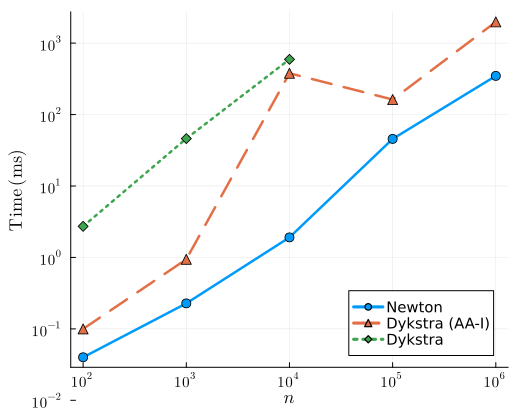

In [17]:
median_ms(bt) = median(bt.times) / 1e6    # ns → ms

function benchmark_one(n::Int; seed::Int = 2025)
    Random.seed!(seed)

    x = 100 .* rand(n)
    x = sort(x; rev = true)
    x[1] = 10 * x[1]

    a1 = zeros(n); a1[end] = -1.0
    a2 = zeros(n); a2[end] = -10.0   # condition number = 10
    a2[1] = 1.0

    specs = [
        (type=:halfspace, α = a1, c = 0.0),
        (type=:halfspace, α = a2, c = 0.0),
        (type=:monoDec,  p = n),
    ]

    r = length(specs)
    rLambda = zeros(n, r)
    x0      = similar(x)

    sets = build_sets(specs; p = length(specs))   # 沿用你原来的写法
    C    = sets[end]

    A = hcat(a1, a2)
    b = zeros(2)

    kwargs2 = (
        A         = A,
        b         = b,
        mode      = :halfspaces,  # hyperplane, halfspaces
        tol       = 1e-12,
        max_outer = 100,
    )

    kwargs = (
        m        = 4,       # memory
        tol      = 1e-12,
        τ        = 1.0,
        maxiter  = 10000,
        λ        = 1e-12,
        cnd_max  = 1e8,
    )

    xN2, λ2, iters2, state2 = project_halfspaces_active_set(C, x; kwargs2...)

    x_AAI,  Λ_AAI,  iters_AAI,  ok_AAI  =
        run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant=:AAI,  kwargs...)
    x_Dy,   Λ_Dy,   iters_Dy,   ok_Dy   =
        run_dykstra!(copy(x0), copy(x), copy(rLambda), sets; AAvariant=:none, kwargs...)

    btime_Newton = @benchmark project_halfspaces_active_set($C, $x; $kwargs2...)
    btime_AAI    = @benchmark run_dykstra!((copy($x0)), (copy($x)), (copy($rLambda)), $sets; AAvariant=:AAI,  $kwargs...)
    btime_Dykstra= @benchmark run_dykstra!((copy($x0)), (copy($x)), (copy($rLambda)), $sets; AAvariant=:none, $kwargs...)

    return (
        n        = n,
        it_AAI   = iters_AAI,
        it_Dyk   = iters_Dy,
        it_Newton= iters2,
        t_AAI    = median_ms(btime_AAI),
        t_Dyk    = median_ms(btime_Dykstra),
        t_Newton = median_ms(btime_Newton),
    )
end

Ns = [100, 1_000, 10_000, 100_000, 1_000_000]
# Ns = [100]

rows_n = Vector{NamedTuple}(undef, length(Ns))

for (k, n) in enumerate(Ns)
    println("Benchmarking n = $n ...")
    rows_n[k] = benchmark_one(n)
end

df_n = DataFrame(rows_n)

println(df_n)

header_n = [
    "n",
    "Iters (AAI)",
    "Iters (Dykstra)",
    "Iters (Newton)",
    "Time AAI (ms)",
    "Time Dykstra (ms)",
    "Time Newton (ms)",
]

pretty_table(df_n;
    header = header_n,
    formatters = (
        ft_printf("%d", 1:4),
        ft_printf("%.3f", 5:7),
    ),
)

# LaTeX 输出
io = IOBuffer()
pretty_table(io, df_n;
    header = header_n,
    tf = tf_latex_booktabs,
    formatters = (
        ft_printf("%d", 1:4),
        ft_printf("%.3f", 5:7),
    ),
)
println("\nLaTeX Table Output:\n")
println(String(take!(io)))

using Plots, LaTeXStrings

default(
    guidefont   = font(12),
    tickfont    = font(10),
    legendfont  = font(10),
    legend      = :bottomright,
    lw          = 2.5,
    markersize  = 5,
)

n_vals    = df_n.n
t_AAI     = df_n.t_AAI
# t_AAII    = df_n.t_AAII
t_Dyk     = df_n.t_Dyk
t_Newton  = df_n.t_Newton

ex_x      = 2:8
xtick_pos = 10.0 .^ ex_x
xtick_lab = [latexstring("10^{", k, "}") for k in ex_x]

ex_y      = -2:8
ytick_pos = 10.0 .^ ex_y
ytick_lab = [latexstring("10^{", k, "}") for k in ex_y]
# 或者：ytick_lab = [L"10^{$(k)}" for k in ex_y]

p = plot(
    n_vals, t_Newton;
    xscale = :log10,
    yscale = :log10,
    xticks = (xtick_pos, xtick_lab),
    yticks = (ytick_pos, ytick_lab),
    xlabel = L"n",
    ylabel = L"\mathrm{Time}\;(\mathrm{ms})",
    label  = "Newton",
    marker = :circle,
    size   = (520, 420),
)

plot!(p, n_vals, t_AAI;   label="Dykstra (AA-I)",  marker=:utriangle, linestyle=:dash)
plot!(p, n_vals[1:3], t_Dyk[1:3];  label="Dykstra", marker=:diamond, linestyle=:dot)
# plot!(p, n_vals, t_Newton;label="Newton",         marker=:diamond,   linestyle=:dot)

savefig(p, "dykstra_newton_benchmarks.pdf")
display(p)




## Example 6: Mean-Variance Portfolia

In [14]:
using CSV, DataFrames, Statistics

df = CSV.read("./datasets/sp500.csv", DataFrame)

prices = Matrix(df[:, 2:end])
logrets = diff(log.(prices); dims=1)
μ = dropdims(mean(logrets; dims=1), dims=1)
Σ = cov(logrets; dims=1)
bad_idx = findall(ismissing, μ)

df_clean = select(df, Not(bad_idx .+ 1))
prices = Matrix(df_clean[:, 2:end])
logrets = diff(log.(prices); dims=1)
logrets = logrets[:, Not(bad_idx)]

μ = dropdims(mean(logrets; dims=1), dims=1)
Σ = cov(logrets; dims=1);
Eret = 0.001


using JuMP, MathOptInterface
using Gurobi

# Mean-Variance Optimization with Gurobi
function mean_variance_optimization(μ::Vector{Float64}, Σ::Matrix{Float64}, 
        target_return::Float64; tol::Float64 = 1e-8, short_selling::Bool=false)
    n = length(μ)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)     # silent mode
    set_optimizer_attribute(model, "BarConvTol", tol)  # tolerance for convergence

    @variable(model, w[1:n])
    @objective(model, Min, dot(w, Σ * w))               # minimize portfolio variance
    @constraint(model, sum(w) == 1)                     # fully invested
    @constraint(model, dot(μ, w) >= target_return)      # target return

    if !short_selling
        @constraint(model, w .>= 0)                     # long-only constraint
    end

    optimize!(model)

    status = termination_status(model)
    if status ∉ [MOI.OPTIMAL, MOI.LOCALLY_SOLVED]
        error("Optimization failed with status: $status")
    end
    
    weights = value.(w)
    @. weights = ifelse(weights < 1e-6, 0.0, weights)
    weights .= weights/sum(weights)
    
    port_return = dot(μ, weights)
    port_variance = dot(weights, Σ * weights)
    port_risk = sqrt(port_variance)
    iters = JuMP.MOI.get(model, MOI.BarrierIterations())

    return weights, port_variance, port_return, port_risk, iters
end


using BenchmarkTools, DataFrames, Statistics, PrettyTables

r = 0.001

tol = 1e-9

w1, var1, ret1, risk1, iter1 = mean_variance_mle_gradient(μ, Σ, Eret, method=:newton, tol = tol, verbose=false)
b1 = @benchmark mean_variance_mle_gradient($μ, $Σ, $Eret, method=:newton, tol = $tol, verbose=false)

w2, var2, ret2, risk2, iter2 = mean_variance_mle_gradient(μ, Σ, Eret, method=:AAI, tol = tol, verbose=false)
b2 = @benchmark mean_variance_mle_gradient($μ, $Σ, $Eret, method=:AAI, tol = $tol, verbose=false)

w3, var3, ret3, risk3, iter3 = mean_variance_mle_gradient(μ, Σ, Eret, method=:dykstra, tol = tol, verbose=false)
b3 = @benchmark mean_variance_mle_gradient($μ, $Σ, $Eret, method=:dykstra, tol = $tol, verbose=false)

w4, var4, ret4, risk4, iter4 = mean_variance_optimization(μ, Σ, r, tol = tol)
b4 = @benchmark mean_variance_optimization($μ, $Σ, $r, tol = tol)


function extract_stats(trial)
    times = trial.times ./ 1e6 
    return (
        minimum = minimum(times),
        median = median(times),
        mean = mean(times),
        std = std(times)
    )
end

s1 = extract_stats(b1)
s2 = extract_stats(b2)
s3 = extract_stats(b3)
s4 = extract_stats(b4)

rows = [
    ("Newton",  s1.mean, iter1, sum(w1 .== 0), ret1, risk1),
    ("AAI",     s2.mean, iter2, sum(w2 .== 0), ret2, risk2),
    ("Dykstra", s3.mean, iter3, sum(w3 .== 0), ret3, risk3),
    ("Gurobi",      s4.mean, iter4, sum(w4 .== 0), ret4, risk4),
]

header = ["Method", "Time(ms)", "Iterations", "# of Zeros", "Return", "Risk"]

df = DataFrame([Symbol(h) => [r[i] for r in rows] for (i, h) in enumerate(header)])

println("\nPretty Table:")
pretty_table(df; 
    header=header, 
    formatters=(
        ft_printf("%.2f", [2]),    # Time
        ft_printf("%.0f", [3,4]),    # Iterations
        ft_printf("%.3f", [5]), 
        ft_printf("%.7f", [6]) 
    )
)

io = IOBuffer()
pretty_table(io, df;
    header=header,
    tf=tf_latex_booktabs,
    formatters=(
        ft_printf("%.2f", [2]),    # Time
        ft_printf("%.0f", [3,4]),    # Iterations
        ft_printf("%.3f", [5]), 
        ft_printf("%.7f", [6]) 
    )
)

println("\nLaTeX Table Output:")
println(String(take!(io)))





Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter BarConvTol to value 1e-09
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter BarConvTol to value 1e-09
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter BarConvTol to value 1e-09
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter BarConvTol to value 1e-09
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set parameter BarConvTol to value 1e-09
Set parameter Username
Set parameter LicenseID to value 2689036
Academic license - for non-commercial use only - expires 2026-07-17
Set para

┌─────────┬──────────┬────────────┬────────────┬────────┬───────────┐
│  Method │ Time(ms) │ Iterations │ # of Zeros │ Return │      Risk │
├─────────┼──────────┼────────────┼────────────┼────────┼───────────┤
│  Newton │    16.61 │        158 │        452 │  0.001 │ 0.0052316 │
│     AAI │    81.33 │        179 │        452 │  0.001 │ 0.0052316 │
│ Dykstra │   144.20 │        158 │        452 │  0.001 │ 0.0052317 │
│  Gurobi │   144.77 │         16 │        452 │  0.001 │ 0.0052316 │
└─────────┴──────────┴────────────┴────────────┴────────┴───────────┘

LaTeX Table Output:
\begin{tabular}{rrrrrr}
  \toprule
  \textbf{Method} & \textbf{Time(ms)} & \textbf{Iterations} & \textbf{\# of Zeros} & \textbf{Return} & \textbf{Risk} \\\midrule
  Newton & 16.61 & 158 & 452 & 0.001 & 0.0052316 \\
  AAI & 81.33 & 179 & 452 & 0.001 & 0.0052316 \\
  Dykstra & 144.20 & 158 & 452 & 0.001 & 0.0052317 \\
  Gurobi & 144.77 & 16 & 452 & 0.001 & 0.0052316 \\\bottomrule
\end{tabular}

